In [1]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c elo-merchant-category-recommendation

 99% 606M/615M [00:03<00:00, 192MB/s]
100% 615M/615M [00:03<00:00, 191MB/s]


In [6]:
! unzip elo-merchant-category-recommendation

Archive:  elo-merchant-category-recommendation.zip
  inflating: Data Dictionary.xlsx    
  inflating: Data_Dictionary.xlsx    
  inflating: historical_transactions.csv  
  inflating: merchants.csv           
  inflating: new_merchant_transactions.csv  
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


###**1. Importing Libraries**

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency,chisquare
from pandas.plotting import scatter_matrix
import plotly.graph_objs as go
import plotly.offline as py
from datetime import datetime, date
import gc
import warnings
warnings.filterwarnings('ignore')

###**2.Loading Datasets**

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
%%time
train = pd.read_csv('/content/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('/content/test.csv', parse_dates=['first_active_month'])


CPU times: user 277 ms, sys: 58.3 ms, total: 335 ms
Wall time: 420 ms


In [10]:
%%time
merchants = reduce_mem_usage(pd.read_csv('/content/merchants.csv'))
historical_transactions = reduce_mem_usage(pd.read_csv('/content/historical_transactions.csv'))
new_transactions = reduce_mem_usage(pd.read_csv('/content/new_merchant_transactions.csv'))
gc.collect()

Mem. usage decreased to 30.32 Mb (46.0% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
CPU times: user 48.3 s, sys: 8.46 s, total: 56.8 s
Wall time: 56.4 s


0

###**3. Explore the train and test data file**

In [11]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [12]:
train.describe()

,feature_1,feature_2,feature_3,target
count,201917.000000,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569,-0.393636
std,1.186160,0.751362,0.495683,3.850500
min,1.000000,1.000000,0.000000,-33.219281
25%,2.000000,1.000000,0.000000,-0.883110
50%,3.000000,2.000000,1.000000,-0.023437
75%,4.000000,2.000000,1.000000,0.765453
max,5.000000,3.000000,1.000000,17.965068


In [13]:
(train.isnull()).sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [14]:
print('The number of rows in train data is:',train.shape[0])
print('The number of rows in test data is:', test.shape[0])

The number of rows in train data is: 201917
The number of rows in test data is: 123623


####**3.1 Feature comparison in train and test data features**

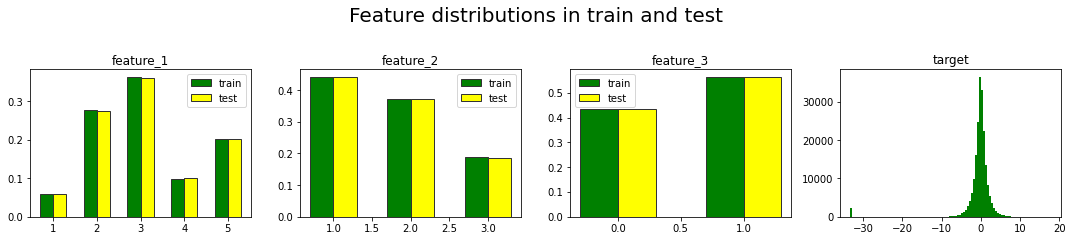

In [17]:
%matplotlib inline

plt.figure(figsize=[15,5])
plt.suptitle('Feature distributions in train and test', fontsize=20, y=1.1)
for num, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'target']):
    plt.subplot(2, 4, num+1)
    if col is not 'target':
        v_c = train[col].value_counts() / train.shape[0]
        plt.bar(v_c.index, v_c, label=('train'), align='edge', width=-0.3, edgecolor=[0.2]*3,color = ('green'))
        v_c = test[col].value_counts() / test.shape[0]
        plt.bar(v_c.index, v_c, label=('test'), align='edge', width=0.3, edgecolor=[0.2]*3,color = ('yellow'))
        plt.title(col)
        plt.legend()
    else:
        plt.hist(train[col], bins = 100, color = ('green'))
        plt.title(col)
    plt.tight_layout()
plt.tight_layout()
plt.show()

Observation
1. The features 1, 2 and 3 are equally train and test distributed.
2. In the target variable, there are few outliers with few scores may be around -30.

In [18]:
outliers = train.loc[train['target'] < -30]
non_outliers = train.loc[train['target'] >= -30]
print('The number of outliers found are',format(outliers.shape[0]))

The number of outliers found are 2207


For now not treating or removing the outliers and may be treat them later if required.

**3.2 Plotting the features 1, 2 and 3 against the target variable**

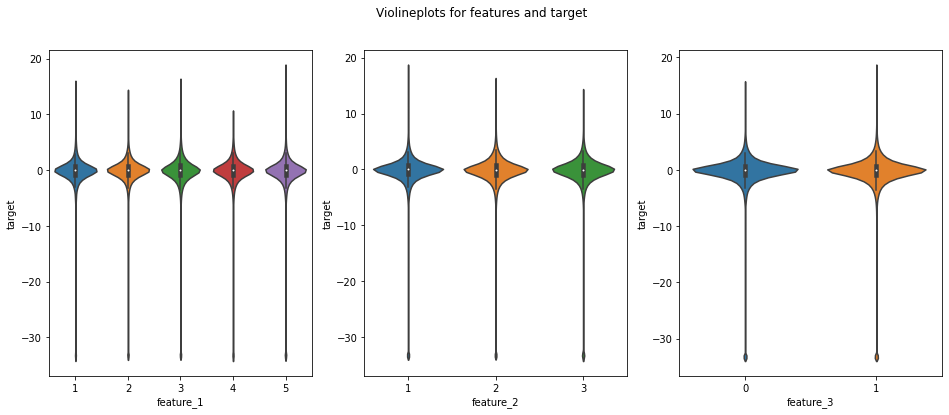

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target');
sns.violinplot(x="feature_1", y="target", data=train, ax=ax[0], title='feature_1');
sns.violinplot(x="feature_2", y="target", data=train, ax=ax[1], title='feature_2');
sns.violinplot(x="feature_3", y="target", data=train, ax=ax[2], title='feature_3');

Not much could be inferred from the distributions as they are similar and could mean that these features may not help in predicting the loyalty scores.

**3.3.Outliers vs Non Outlier comparisons distributions**

In [20]:
outliers_in_target= train.loc[train['target']< -30]
print(' The number of outliers in the data is:',outliers_in_target.shape[0])
non_outliers_in_target= train.loc[train['target'] >=-30]
print(' The number of non-outliers in the data is:',non_outliers_in_target.shape[0])

 The number of outliers in the data is: 2207
 The number of non-outliers in the data is: 199710


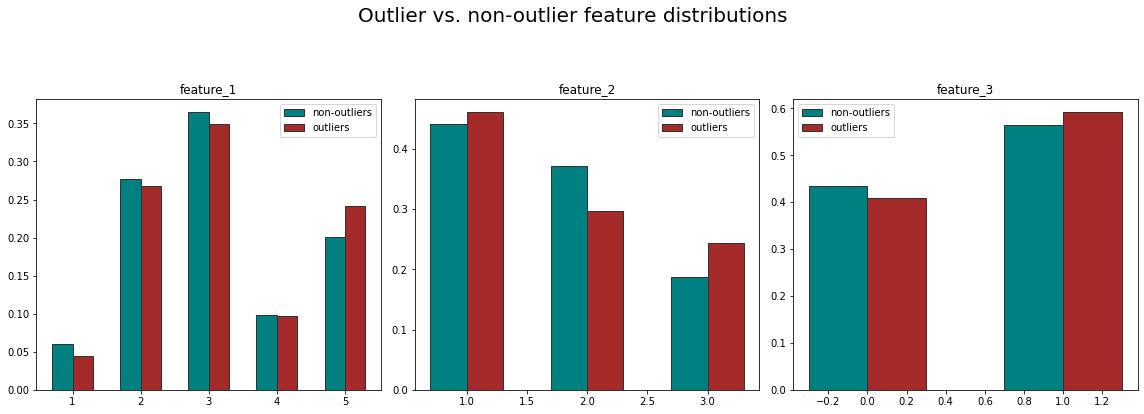

In [21]:
plt.figure(figsize=[16,9])
plt.suptitle('Outlier vs. non-outlier feature distributions', fontsize=20, y=1.1)

for num, col in enumerate(['feature_1', 'feature_2', 'feature_3', 'target']):
    if col is not 'target':
        plt.subplot(2, 3, num+1)
        non_outlier = non_outliers_in_target[col].value_counts() / non_outliers_in_target.shape[0]
        plt.bar(non_outlier.index, non_outlier, label=('non-outliers'), align='edge', width=-0.3, edgecolor=[0.2]*3,color=['teal'])
        outlier = outliers_in_target[col].value_counts() / outliers_in_target.shape[0]
        plt.bar(outlier.index, outlier, label=('outliers'), align='edge', width=0.3, edgecolor=[0.2]*3,color=['brown'])
        plt.title(col)
        plt.legend()

plt.tight_layout()
plt.show()

There are only slight differences between outliers and non-outliers, but they don't seem to be that big and they certainly can't explain the difference between the target values, at least based on the features in the train dataset. It means the card_id's having outliers as loyality score having pretty much similar properties to the regular ones.

**3.4 Correlation between the features**

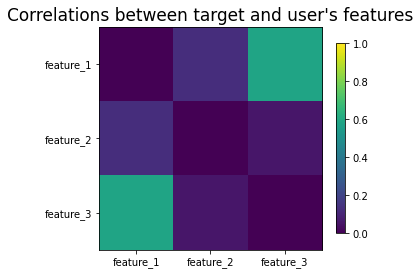

In [22]:
train_corr=train.drop(['first_active_month','card_id','target'],axis=1)
corrs = np.abs(train_corr.corr())
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[5,5])
plt.imshow(corrs,  vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(corrs.columns))
plt.yticks(range(corrs.shape[0]), list(corrs.columns))
plt.title('Correlations between target and user\'s features', fontsize=17)
plt.show()

From the above correlation, we can say that features 1 and 3 are correlated.

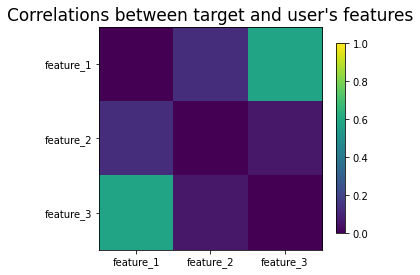

In [23]:
test_corr=test.drop(['first_active_month','card_id'],axis=1)
corrs = np.abs(test_corr.corr())
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[5,5])
plt.imshow(corrs,  vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(corrs.columns))
plt.yticks(range(corrs.shape[0]), list(corrs.columns))
plt.title('Correlations between target and user\'s features', fontsize=17)
plt.show()

Same is the case in test, looks like features 1 and 3 are correlated.

**3.5 Distribution of Active First Month in both Train and Test**

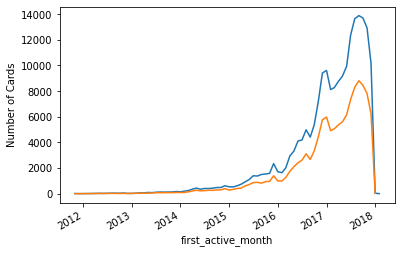

In [24]:
fir_mon = train['first_active_month'].value_counts()
mon = test['first_active_month'].value_counts()
fir_mon.plot()
mon.plot()
plt.ylabel('Number of Cards')
plt.xlabel('first_active_month')
plt.show()

The first active month indicates the month of first purchase and the distribution seems to be increasing over the month and years progresses.

###**4.Historical Transactions**

In [25]:
historical_transactions.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   authorized_flag       29112361 non-null  object 
 1   card_id               29112361 non-null  object 
 2   city_id               29112361 non-null  int16  
 3   category_1            29112361 non-null  object 
 4   installments          29112361 non-null  int16  
 5   category_3            28934202 non-null  object 
 6   merchant_category_id  29112361 non-null  int16  
 7   merchant_id           28973880 non-null  object 
 8   month_lag             29112361 non-null  int8   
 9   purchase_amount       29112361 non-null  float32
 10  purchase_date         29112361 non-null  object 
 11  category_2            26459497 non-null  float16
 12  state_id              29112361 non-null  int8   
 13  subsector_id          29112361 non-null  int8   
dtypes: float16(1), f

**4.1 Check for Missing Values**

In [26]:
(historical_transactions.isnull()).sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [27]:
target_feature= train['target']

In [28]:
k=['category_3','merchant_id','category_2']
for k in historical_transactions[k]:
  print('The percentage of Nan values in {} is {:4.1f} percent'.format(k,historical_transactions[k].isnull().sum() * 100 / len(historical_transactions[k])))

The percentage of Nan values in category_3 is  0.6 percent
The percentage of Nan values in merchant_id is  0.5 percent
The percentage of Nan values in category_2 is  9.1 percent


In [29]:
historical_transactions['category_2'].fillna(1,inplace=True)# Replacing with most occured values
historical_transactions['category_3'].fillna('A',inplace=True)
historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)


**4.2 Historical Transaction info**

In [30]:
print(' The number of rows is {} and columns is {} in the dataset '.format(historical_transactions.shape[0],historical_transactions.shape[1]))
print(' The First five rows of the historical transaction is:') 
historical_transactions.head()

 The number of rows is 29112361 and columns is 14 in the dataset 
 The First five rows of the historical transaction is:


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


**4.3 Authorized Card Flag**

In [31]:
# Convert the authorized_flag to a binary value.
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [43]:
print(f"At average {historical_transactions['authorized_flag'].mean() * 100:.4f}% transactions are authorized")

At average 91.3545% transactions are authorized


In [33]:
autorized_card_rate = historical_transactions.groupby(['card_id'])['authorized_flag'].mean().sort_values()
autorized_card_rate.head()

card_id
C_ID_744d26ea32    0.030488
C_ID_bb8dd137c9    0.037037
C_ID_e56202cd39    0.042105
C_ID_4feacff118    0.050000
C_ID_c27b4f80f7    0.054545
Name: authorized_flag, dtype: float64

Cards with lowest and highest percentage of authorized transactions. The range seems to be within 0.03 and 0.55

In [37]:
historical_transactions[["month_lag","installments","month_lag","installments"]].describe()
historical_transactions.groupby("authorized_flag").size()
historical_transactions.groupby("category_3").size()
historical_transactions.groupby("category_1").size()
historical_transactions.groupby("category_2").size()

category_2
1.0    17830063
2.0     1026535
3.0     3911795
4.0     2618053
5.0     3725915
dtype: int64

In [38]:
# converting purchase time string into datetime
historical_transactions['purchase_date'] = historical_transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

**4.4 Histogram Plot and Analyse for each individual feature**

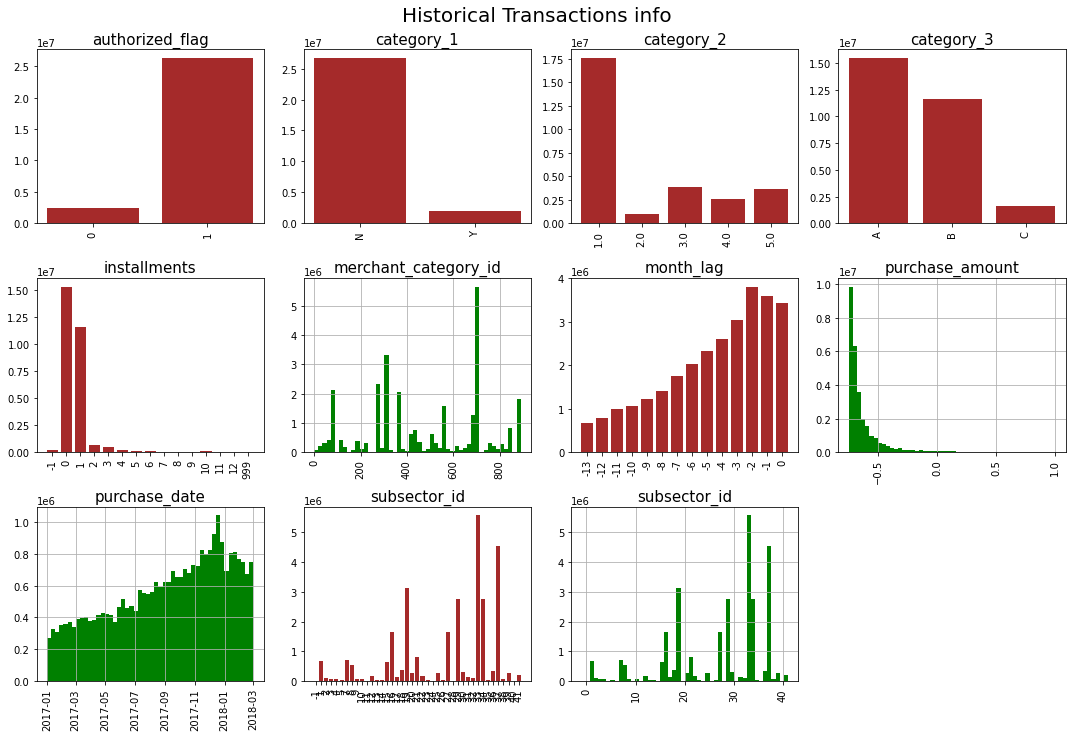

In [44]:
# drawing histograms for each column of filtered_trns_history
filtered_trns_history = historical_transactions.loc[historical_transactions['purchase_amount'] < 1]
cat_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2', 'subsector_id']
num_cols = ['purchase_amount', 'purchase_date', 'merchant_category_id', 'subsector_id']

plt.figure(figsize=[15, 10])
plt.suptitle('Historical Transactions info', y=1.02, fontsize=20)
ncols = 4
nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
last_ind = 0
for col in sorted(list(filtered_trns_history.columns)):
    #print('processing column ' + col)
    if col in cat_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = filtered_trns_history[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color=('brown'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    if col in num_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        filtered_trns_history[col].hist(bins = 50, color=('green'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    plt.tight_layout()

1. Most of the transactions are authorized historically and need to check the same in the new transactions.
2. Installments seem to have outliers or different values like -1 and 999, we can either remove them or replace them accordingly
3. t seems that almost all transactions have purchase amount in range (-1, 0). Quite a strong normalization and high outliers

In [50]:
# converting category_1, authorized_flag and category_3 values to numeric ones, so we can use then in scatter plots and correlation coefficients
filtered_trns_history['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
filtered_trns_history['category_1'].replace({'N':0, 'Y':1}, inplace=True)
filtered_trns_history['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

**4.5 Correlations between columns in Historical Transactions**

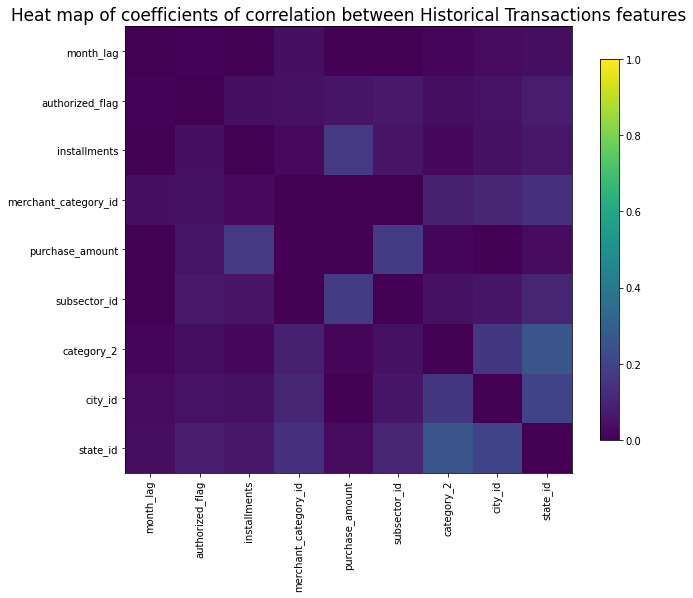

In [45]:
# correlations between columns in historical_transactions:
corrs = np.abs(filtered_trns_history.corr())
ordered_cols = (corrs).sum().sort_values().index
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corrs.loc[ordered_cols, ordered_cols], vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corrs.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between Historical Transactions features', fontsize=17)
plt.show()

1. State id and city id seem to have the highest correlated features among the features.
2. Category 2 looks correlated with the state id and the city id.

**4.6 Ploting the sum of transaction amounts against the loyalty score**

In [46]:
gdf = historical_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train, gdf, on="card_id", how="left")

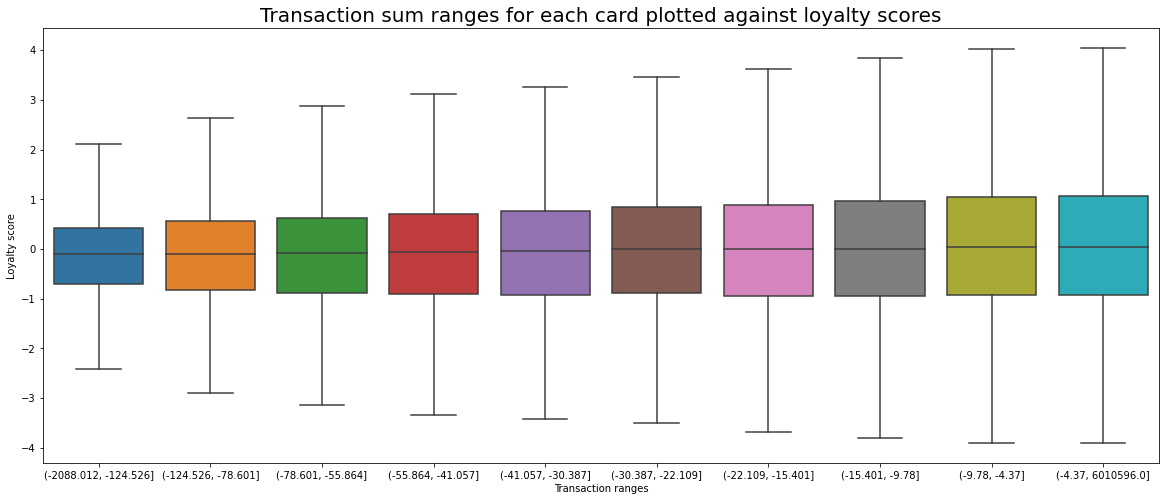

In [42]:
bins = np.percentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)

plt.figure(figsize=(20,8))
sns.boxplot(x="binned_sum_hist_trans", y=train_df['target'], data=train_df, showfliers=False)
#plt.xticks(rotation='vertical')
plt.xlabel('Transaction ranges')
plt.ylabel('Loyalty score')
plt.title("Transaction sum ranges for each card plotted against loyalty scores", fontsize = 20)
plt.show()

We can see that the loyalty scores are increasingly as the sum of transactions are increasing.

### **5. New Merchant Transactions Exploration**

In [49]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


**5.1 Check for Missing Values**

In [51]:
(new_transactions.isnull()).sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

Same categories as the historical transactions are missing in the new transactions.

In [52]:
k=['category_3','merchant_id','category_2']
for k in new_transactions[k]:
  print('The percentage of Nan values in {} is {:4.1f} percent'.format(k,new_transactions[k].isnull().sum() * 100 / len(new_transactions[k])))

The percentage of Nan values in category_3 is  2.8 percent
The percentage of Nan values in merchant_id is  1.3 percent
The percentage of Nan values in category_2 is  5.7 percent


In [53]:
new_transactions['category_2'].fillna(1,inplace=True)# Replacing with most occured values
new_transactions['category_3'].fillna('A',inplace=True)
new_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)


**5.2 New Transaction info**

In [50]:
new_transactions.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   authorized_flag       1963031 non-null  object 
 1   card_id               1963031 non-null  object 
 2   city_id               1963031 non-null  int16  
 3   category_1            1963031 non-null  object 
 4   installments          1963031 non-null  int16  
 5   category_3            1907109 non-null  object 
 6   merchant_category_id  1963031 non-null  int16  
 7   merchant_id           1936815 non-null  object 
 8   month_lag             1963031 non-null  int8   
 9   purchase_amount       1963031 non-null  float16
 10  purchase_date         1963031 non-null  object 
 11  category_2            1851286 non-null  float16
 12  state_id              1963031 non-null  int8   
 13  subsector_id          1963031 non-null  int8   
dtypes: float16(2), int16(3), int8(3), 

More or less the features between the old and new transactions are same and this is expected, but distributions could vary with time.

In [54]:
print(' The number of rows is {} and columns is {} in the dataset '.format(historical_transactions.shape[0],historical_transactions.shape[1]))
print(' The First five rows of the historical transaction is:') 
new_transactions.head()

 The number of rows is 29112361 and columns is 14 in the dataset 
 The First five rows of the historical transaction is:


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,1.0,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,1.0,-1,29


**5.3 Histogram Plot and Analyse for each individual feature**

In [55]:
# converting purchase time string into datetime
new_transactions['purchase_date'] = new_transactions['purchase_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

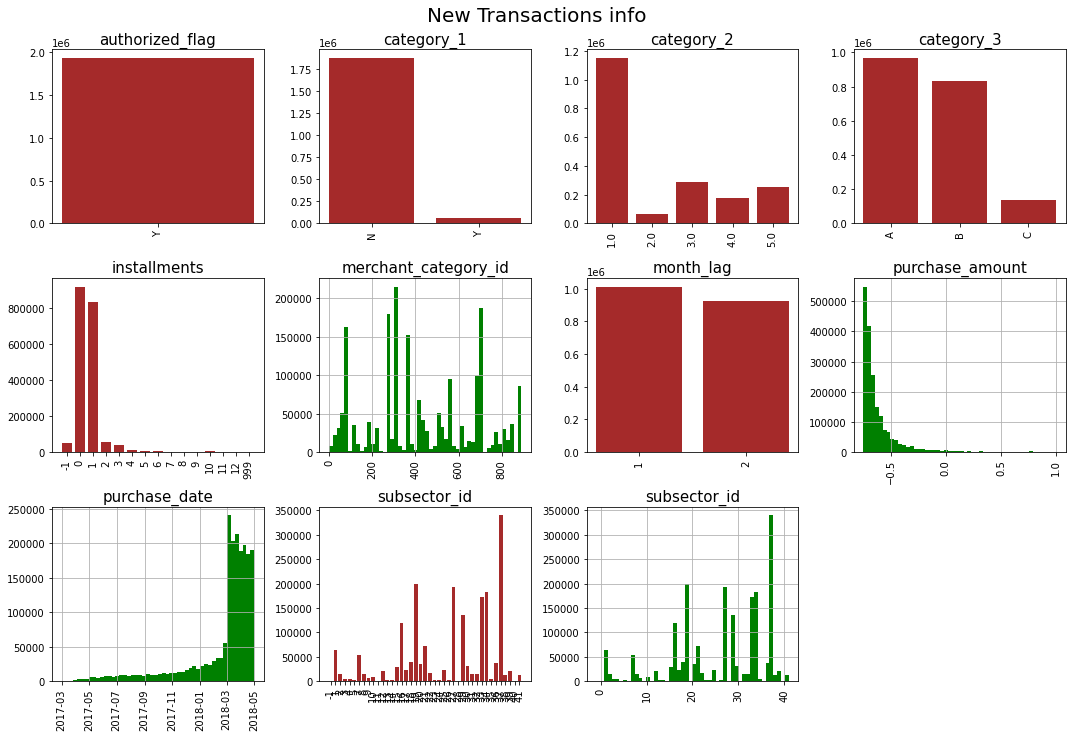

In [56]:
# plotting histograms for each column of filtered_new_trns
filtered_new_trns = new_transactions.loc[new_transactions['purchase_amount'] < 1]
cat_cols = ['authorized_flag', 'category_1', 'installments','category_3', 'month_lag','category_2', 'subsector_id']
num_cols = ['purchase_amount', 'purchase_date', 'merchant_category_id', 'subsector_id']

plt.figure(figsize=[15, 10])
plt.suptitle('New Transactions info', y=1.02, fontsize=20)
ncols = 4
nrows = int(np.ceil((len(cat_cols) + len(num_cols))/4))
last_ind = 0
for col in sorted(list(filtered_new_trns.columns)):
    #print('processing column ' + col)
    if col in cat_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        vc = filtered_new_trns[col].value_counts()
        x = np.array(vc.index)
        y = vc.values
        inds = np.argsort(x)
        x = x[inds].astype(str)
        y = y[inds]
        plt.bar(x, y, color=('brown'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    if col in num_cols:
        last_ind += 1
        plt.subplot(nrows, ncols, last_ind)
        filtered_new_trns[col].hist(bins = 50, color=('green'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    plt.tight_layout()

1. All of the transactions are authorized in the latest transactions info and hence we can drop this feature.
2. Installments seem to have outliers or different values like -1 and 999, we can either remove them or replace them accordingly
3. It seems that almost all transactions have purchase amount in range (-1, 0).quite a strong normalization and high outliers.
4. Most of the purchase date for the cards seem to happen after 2018.

In [57]:
# converting category_1, authorized_flag and category_3 values to numeric ones, so we can use then in scatter plots and correlation coefficients
filtered_new_trns['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
filtered_new_trns['category_1'].replace({'N':0, 'Y':1}, inplace=True)
filtered_new_trns['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

**5.4 Correlations between columns in New Transactions**

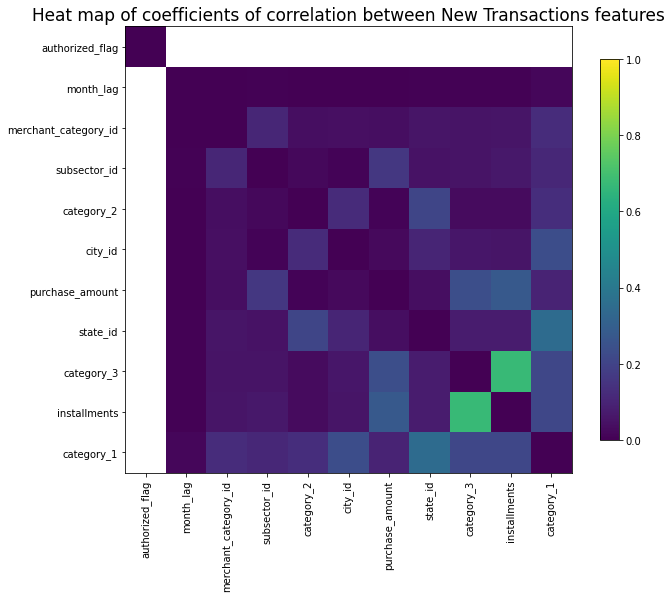

In [58]:
# correlations between columns in  new transactions:
corrs = np.abs(filtered_new_trns.corr())
ordered_cols = (corrs).sum().sort_values().index
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corrs.loc[ordered_cols, ordered_cols], vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corrs.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between New Transactions features', fontsize=17)
plt.show()

1. A very high correlation is seen between Installments and Category 3 variables.
2. State id and city id seem to have the highest correlated features among the features.
3. Category 2 looks correlated with the state id and the city id.

**5.5 Ploting the sum of transaction amounts against the loyalty score**

In [68]:
gdf = new_transactions.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train, gdf, on="card_id", how="left")

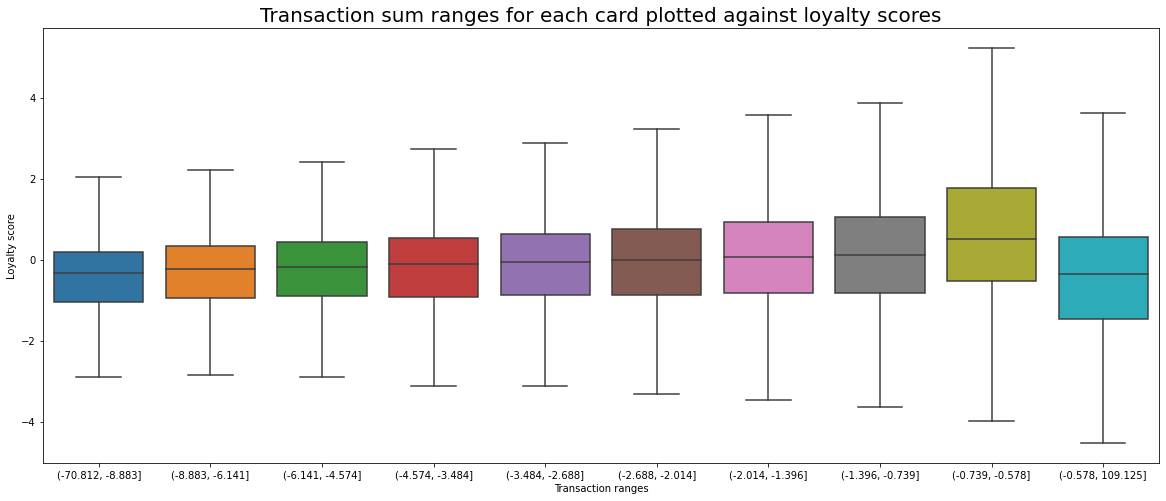

In [70]:
bins = np.nanpercentile(train_df["sum_hist_trans"], range(0,101,10))
train_df['binned_sum_hist_trans'] = pd.cut(train_df['sum_hist_trans'], bins)

plt.figure(figsize=(20,8))
sns.boxplot(x="binned_sum_hist_trans", y=train_df['target'], data=train_df, showfliers=False)
#plt.xticks(rotation='vertical')
plt.xlabel('Transaction ranges')
plt.ylabel('Loyalty score')
plt.title("Transaction sum ranges for each card plotted against loyalty scores", fontsize = 20)
plt.show()

1. Here as the sum of new merchant transactions is increasing the loyalty also seems to be increasing except the last bin.
2. This could be because of the effect of the outliers on the last bin.

### **6. Merchant Data exploration**

**6.1 Check for Missing Values**

In [76]:
(merchants.isnull()).sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [77]:
merchants['avg_sales_lag3'].fillna(1,inplace=True)
merchants['avg_sales_lag6'].fillna(1,inplace=True)
merchants['avg_sales_lag12'].fillna(1,inplace=True)
merchants['category_2'].fillna(1,inplace=True)

In [78]:
merchants.dtypes

merchant_id                     object
merchant_group_id                int32
merchant_category_id             int16
subsector_id                      int8
numerical_1                    float16
numerical_2                    float16
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float32
avg_purchases_lag3             float64
active_months_lag3                int8
avg_sales_lag6                 float32
avg_purchases_lag6             float64
active_months_lag6                int8
avg_sales_lag12                float32
avg_purchases_lag12            float64
active_months_lag12               int8
category_4                      object
city_id                          int16
state_id                          int8
category_2                     float16
dtype: object

**6.2 Merchants info**

In [79]:
merchants.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int32  
 2   merchant_category_id         334696 non-null  int16  
 3   subsector_id                 334696 non-null  int8   
 4   numerical_1                  334696 non-null  float16
 5   numerical_2                  334696 non-null  float16
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334696 non-null  float32
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int8   
 12  avg_sales_lag6               334696 non-null  float32
 13 

In [81]:
print(' The number of rows is {} and columns is {} in the dataset '.format(merchants.shape[0],merchants.shape[1]))
print(' The First five rows of the historical transaction is:') 
merchants.head()

 The number of rows is 334696 and columns is 22 in the dataset 
 The First five rows of the historical transaction is:


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,1.000000,...,1.000000,4.666667,6,1.000000,3.833333,12,Y,-1,-1,1.0
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,1.000000,...,1.000000,0.361111,6,1.000000,0.347222,12,Y,-1,-1,1.0


**6.3 Histogram Plot and Analyse for each individual feature**

In [82]:
# Several columns in merchants.csv have outliers that squeeze most of the data into one bin. Let's fix that by removing those outliers:
clean_merchants = merchants.loc[(merchants['numerical_1'] < 0.1) &
                               (merchants['numerical_2'] < 0.1) &
                               (merchants['avg_sales_lag3'] < 5) &
                               (merchants['avg_purchases_lag3'] < 5) &
                               (merchants['avg_sales_lag6'] < 10) &
                               (merchants['avg_purchases_lag6'] < 10) &
                               (merchants['avg_sales_lag12'] < 10) &
                               (merchants['avg_purchases_lag12'] < 10)]

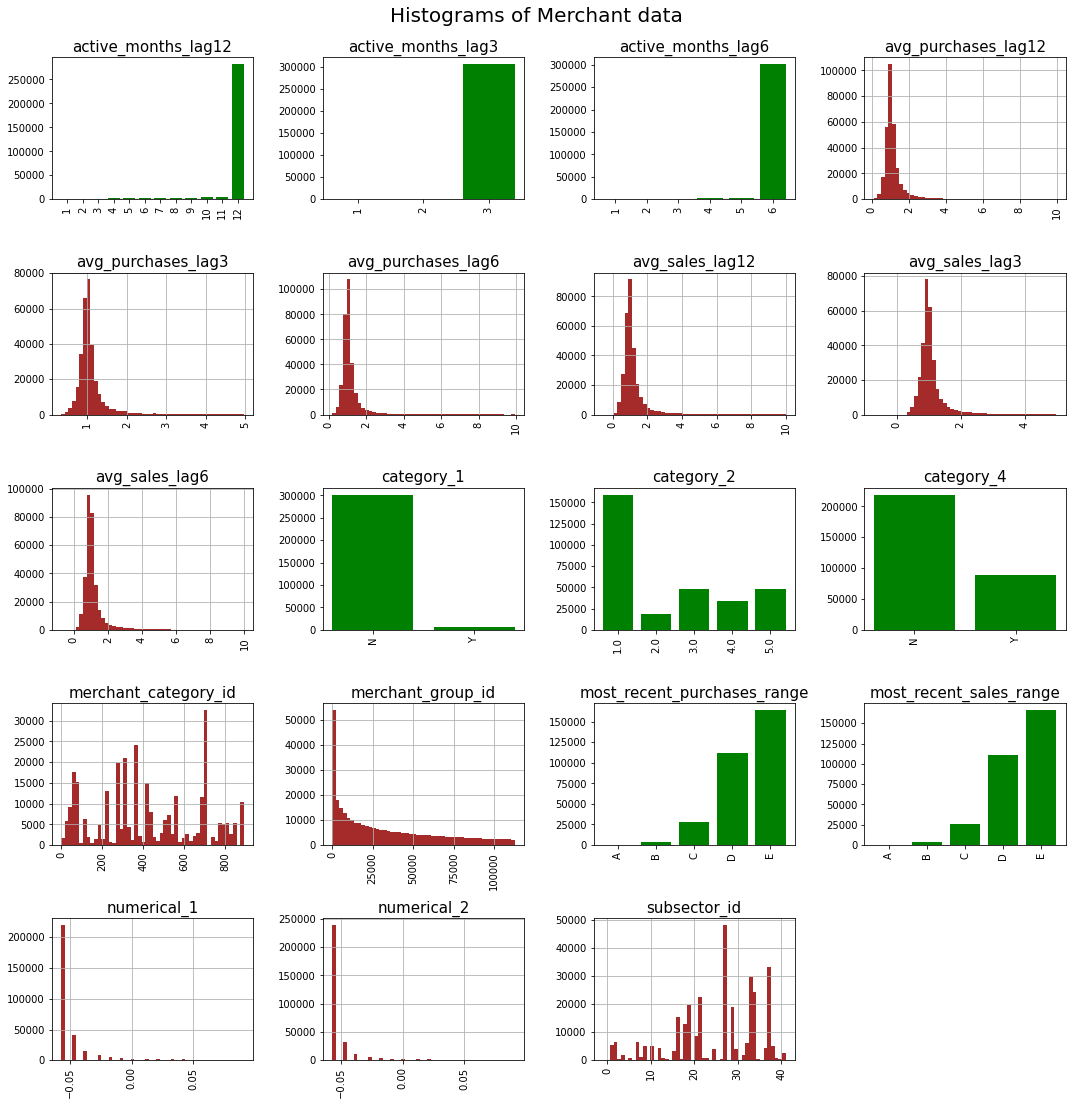

In [83]:
category_columns = ['active_months_lag6','active_months_lag3','most_recent_sales_range', 'most_recent_purchases_range','category_1','active_months_lag12','category_4', 'category_2']
numeral_columns = ['numerical_1', 'numerical_2','merchant_group_id','merchant_category_id','avg_sales_lag3', 'avg_purchases_lag3', 'subsector_id', 'avg_sales_lag6', 'avg_purchases_lag6', 'avg_sales_lag12', 'avg_purchases_lag12']

plt.figure(figsize=[15, 15])
plt.suptitle('Histograms of Merchant data', y=1.02, fontsize=20)
number_of_columns = 4
number_of_rows = int(np.ceil((len(category_columns) + len(numeral_columns))/4))
last_index = 0
for col in sorted(list(clean_merchants.columns)):
    #print('processing column ' + col)
    if col in category_columns:
        last_index += 1
        plt.subplot(number_of_rows, number_of_columns, last_index)
        value_count = clean_merchants[col].value_counts()
        x = np.array(value_count.index)
        y = value_count.values
        indexes = np.argsort(x)
        x = x[indexes].astype(str)
        y = y[indexes]
        plt.bar(x, y, color=('green'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    if col in numeral_columns:
        last_index += 1
        plt.subplot(number_of_rows, number_of_columns, last_index)
        clean_merchants[col].hist(bins = 50, color=('brown'))
        plt.title(col, fontsize=15)
        plt.xticks(rotation=90)
    plt.tight_layout()

1. Numerical 1 and 2 are discrete values and both are look similarly distributed.


**6.4 Correlations between columns in Merchants**

In [84]:
clean_merchants['most_recent_purchases_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
clean_merchants['most_recent_sales_range'].replace({'A':4, 'B':3, 'C':2, 'D':1, 'E':0}, inplace=True)
clean_merchants['category_1'].replace({'N':0, 'Y':1}, inplace=True)

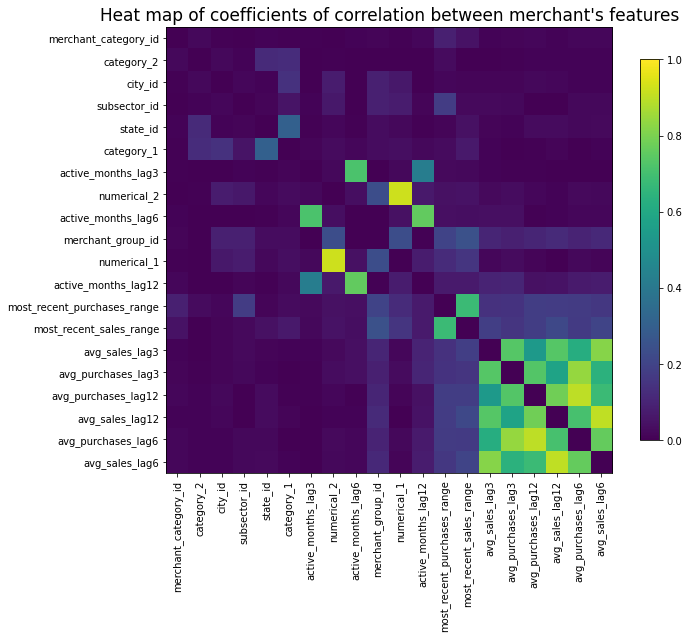

In [85]:
corrs = np.abs(clean_merchants.corr())
ordered_cols = (corrs).sum().sort_values().index
np.fill_diagonal(corrs.values, 0)
plt.figure(figsize=[10,10])
plt.imshow(corrs.loc[ordered_cols, ordered_cols], vmin=0, vmax=1)
plt.colorbar(shrink=0.7)
plt.xticks(range(corrs.shape[0]), list(ordered_cols), rotation=90)
plt.yticks(range(corrs.shape[0]), list(ordered_cols))
plt.title('Heat map of coefficients of correlation between merchant\'s features', fontsize=17)
plt.show()

1. Lot of highly correlated features between numbericals and sales columns.
2. numerical_1 and numerical_2 are highly correlated.
3. Avg_sales and avg_purchases within the last 3, 6, and 12 months are highly correlated
4. category_1 is may be correlated with the merchant's city_id and merchant's state_id.

**6.5 Avergage sales and number of purchases**

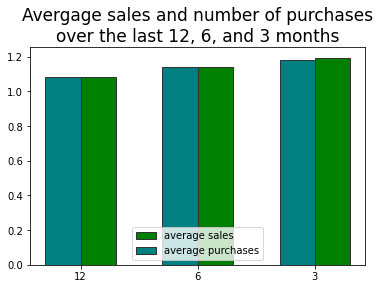

In [89]:
x = np.array([12, 6, 3]).astype(str)
sales_rates = clean_merchants[['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']].mean().values
purchase_rates = clean_merchants[['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']].mean().values
plt.bar(x, sales_rates, width=0.3, align='edge', label='average sales',color='green', edgecolor=[0.2]*3)
plt.bar(x, purchase_rates, width=-0.3, align='edge', label='average purchases',color='teal',  edgecolor=[0.2]*3)
plt.legend()
plt.title('Avergage sales and number of purchases\nover the last 12, 6, and 3 months', fontsize=17)
plt.show()

1. The last 3 months seems to be good with regards to sales and purchases.
2. We can drop the Average sales of 3 months and 6 months as these are the truncated versions of the Average sales of 12 months

**6.6 Duplicates Check and Drop**

In [93]:
clean_merchants = clean_merchants.drop_duplicates()
print('Number of duplicates in merchants.csv using all features:',clean_merchants.shape[0]-clean_merchants.shape[0])

Number of duplicates in merchants.csv using all features: 0


###**7. Exploring Common card_id's between datasets**

In [92]:
def isin(a,b):
    From = pd.DataFrame(a)
    To = pd.DataFrame(b)
    return(np.mean(From[0].isin(To[0]))*100)

**Train vs rest**

In [94]:
print(isin(train["card_id"].unique(),test["card_id"].unique()), '% of unique credit cards from train in test')
print(isin(train["card_id"].unique(),filtered_trns_history["card_id"].unique()), '% of unique credit cards from train in historical_transactions')
print(isin(train["card_id"].unique(),filtered_new_trns["card_id"].unique()), '% of unique credit cards from train in new_merchant_transactions')

0.0 % of unique credit cards from train in test
99.98860918100011 % of unique credit cards from train in historical_transactions
88.64137244511359 % of unique credit cards from train in new_merchant_transactions


**Test vs rest**

In [95]:
print(isin(test["card_id"].unique(),train["card_id"].unique()), '% of unique credit cards from test in train')
print(isin(test["card_id"].unique(),filtered_trns_history["card_id"].unique()), '% of unique credit cards from test in historical_transactions')
print(isin(test["card_id"].unique(),filtered_new_trns["card_id"].unique()), '% of unique credit cards from test in new_merchant_transactions')

0.0 % of unique credit cards from test in train
99.98705742458928 % of unique credit cards from test in historical_transactions
88.47220986386029 % of unique credit cards from test in new_merchant_transactions


**Historical Transactions vs rest**

In [97]:
print(isin(filtered_trns_history["card_id"].unique(),filtered_new_trns["card_id"].unique()), '% of unique credit cards from historical_transactions in new_merchant_transactions')
print(isin(filtered_trns_history["merchant_id"].unique(),clean_merchants["merchant_id"].unique()), '% of unique merchants from historical_transactions in merchants')

88.58375243086812 % of unique credit cards from historical_transactions in new_merchant_transactions
91.8928693974831 % of unique merchants from historical_transactions in merchants


***Refernces***

https://www.kaggle.com/code/batalov/making-sense-of-elo-data-eda/notebook
https://www.kaggle.com/code/roydatascience/elo-stack-with-goss-boosting/notebook
https://www.kaggle.com/code/kundnjha/make-sense-out-of-nonsense-elo-eda